In [28]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import sklearn

from pandas import Series, DataFrame
from pylab import rcParams
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report

In [29]:
metadata=pd.read_csv("movie_metadata_with_score_metacritic.csv", index_col="Unnamed: 0") #reading in metacritic dataset
metadata=metadata.loc[~metadata["metacritic_metascore"].isna()] #removing rows with no metacritic data
metadata=metadata.drop(["homepage","keywords","overview","status","tagline","imdb_metascore","budget","revenue"],1) #dropping unnecessary features
metadata=metadata.drop_duplicates() #dropping duplicates
metadata["release_year"]=metadata.release_date.str[0:4].astype(int) #creating new column with year for comparison


In [30]:
num_data=pd.read_csv("the_numbers_budget.csv") #reading in revenue data
num_data=num_data.rename(columns={"Movie":"title"}) #renaming column to match metadata
num_data["num_year"]=num_data["Release Date"].str[-4:].astype(int)
num_data=num_data.drop_duplicates()#dropping duplicates

In [31]:
critic_revenue=metadata.merge(num_data,on="title") #merging datasets
critic_revenue=critic_revenue.drop_duplicates() #dropping duplicates
critic_revenue=critic_revenue.loc[(critic_revenue["Worldwide Gross"]!=0)] #removing rows with no revenue data
critic_revenue=critic_revenue.loc[(np.abs(critic_revenue.release_year-critic_revenue.num_year)<5)] #removing rows where the years don't match, as this indicates different movies

critic_revenue["log Worldwide Gross"]=np.log(critic_revenue["Worldwide Gross"])#adding column for log of revenue

In [32]:
#Normalizing by the median for merged data set

critic_revenue["Production Budget"]=(critic_revenue["Production Budget"]-critic_revenue["Production Budget"].median())/critic_revenue["Production Budget"].std()
critic_revenue["Worldwide Gross"]=(critic_revenue["Worldwide Gross"]-critic_revenue["Worldwide Gross"].median())/critic_revenue["Worldwide Gross"].std()
critic_revenue["log Worldwide Gross"]=(critic_revenue["log Worldwide Gross"]-critic_revenue["log Worldwide Gross"].median())/critic_revenue["log Worldwide Gross"].std()
critic_revenue["Domestic Gross"]=(critic_revenue["Domestic Gross"]-critic_revenue["Domestic Gross"].median())/critic_revenue["Domestic Gross"].std()
critic_revenue["popularity"]=(critic_revenue["popularity"]-critic_revenue["popularity"].median())/critic_revenue["popularity"].std()
critic_revenue["vote_count"]=(critic_revenue["vote_count"]-critic_revenue["vote_count"].median())/critic_revenue["vote_count"].std()
critic_revenue["metacritic_metascore"]=(critic_revenue["metacritic_metascore"]-critic_revenue["metacritic_metascore"].median())/critic_revenue["metacritic_metascore"].std()
critic_revenue["runtime"]=(critic_revenue["runtime"]-critic_revenue["runtime"].median())/critic_revenue["runtime"].std()

# Reindex since the dataset has been subset many times
critic_revenue.index=range(len(critic_revenue))

In [33]:
critic_revenue.head()

,genres,id,original_language,original_title,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,...,vote_average,vote_count,metacritic_metascore,release_year,Release Date,Production Budget,Domestic Gross,Worldwide Gross,num_year,log Worldwide Gross
0,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",19995,en,Avatar,4.052175,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2.780384,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",...,7.2,8.616315,1.531581,2009,12/18/2009,9.582076,10.811447,15.431733,2009,1.841058
1,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",206647,en,Spectre,2.744619,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,2.097483,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",...,6.3,3.095912,0.273497,2015,11/6/2015,6.617325,2.547645,4.723337,2015,1.333316
2,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",49026,en,The Dark Knight Rises,2.894507,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,2.926720,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",...,7.6,6.588504,1.258084,2012,7/20/2012,6.024375,6.205456,5.879685,2012,1.425786
3,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",49529,en,John Carter,0.817942,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,1.317024,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",...,6.1,1.333056,-0.218797,2012,3/9/2012,6.024375,0.674754,1.353723,2012,0.832011
4,"[{""id"": 16, ""name"": ""Animation""}, {""id"": 10751...",38757,en,Tangled,0.962329,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2010-11-24,-0.243893,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",...,7.4,2.240829,0.875189,2010,11/24/2010,5.668605,2.558671,3.068326,2010,1.154252


In [34]:
critic_revenue.describe()

,id,popularity,runtime,vote_average,vote_count,metacritic_metascore,release_year,Production Budget,Domestic Gross,Worldwide Gross,num_year,log Worldwide Gross
count,3319.000000,3319.000000,3319.000000,3319.000000,3319.000000,3319.000000,3319.000000,3319.000000,3319.000000,3319.000000,3319.000000,3319.000000
mean,46881.441699,0.249633,0.171291,6.227900,0.357768,-0.029237,2003.434167,0.355301,0.332076,0.352414,2003.547755,-0.203595
std,76554.878539,1.000000,1.000000,0.897374,1.000000,1.000000,10.070777,1.000000,1.000000,1.000000,10.100582,1.000000
min,12.000000,-0.515767,-5.121761,0.000000,-0.265708,-2.953763,1934.000000,-0.497912,-0.402523,-0.242766,1934.000000,-6.325183
25%,7871.500000,-0.285933,-0.487787,5.700000,-0.182909,-0.765790,2000.000000,-0.296475,-0.301383,-0.180317,2000.000000,-0.599780
50%,12271.000000,0.000000,0.000000,6.300000,0.000000,0.000000,2005.000000,0.000000,0.000000,0.000000,2005.000000,0.000000
75%,46515.500000,0.478621,0.658512,6.800000,0.444854,0.711091,2010.000000,0.664104,0.544305,0.447711,2010.000000,0.461749
max,417859.000000,26.071431,11.365431,9.300000,10.085613,2.461469,2016.000000,9.582076,10.811447,15.431733,2017.000000,1.841058


In [35]:
critic_revenue.shape[0]

3319

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.linear_model import LogisticRegression # to apply the Logistic regression
from sklearn.model_selection import train_test_split # to split the data into two parts

In [37]:
%matplotlib inline
rcParams['figure.figsize'] = 10, 8
sb.set_style('whitegrid')

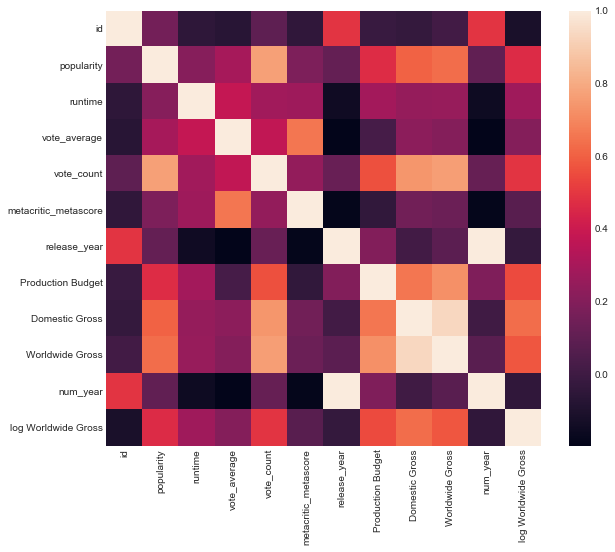

In [38]:
sns.heatmap(critic_revenue.corr(), vmax=1, square=True)

In [39]:
#Defining features and target for this dataset based on co-relation
features = ['metacritic_metascore']
target = ['Worldwide Gross']

In [40]:
#splitting data set into training and test data set in 0.7/0.3
train, test = train_test_split(critic_revenue,test_size=0.30)
train.head()

,genres,id,original_language,original_title,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,...,vote_average,vote_count,metacritic_metascore,release_year,Release Date,Production Budget,Domestic Gross,Worldwide Gross,num_year,log Worldwide Gross
908,"[{""id"": 36, ""name"": ""History""}, {""id"": 18, ""na...",10858,en,Nixon,-0.401435,"[{""name"": ""Hollywood Pictures"", ""id"": 915}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1995-12-22,4.243744,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",...,7.1,-0.212265,0.601692,1995,12/20/1995,0.569232,-0.200980,-0.047039,1995,-0.095141
755,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 10751, ""...",9969,en,Deck the Halls,-0.335166,"[{""name"": ""Regency Enterprises"", ""id"": 508}, {...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2006-11-22,-0.585344,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",...,5.1,-0.183662,-1.476881,2006,11/22/2006,0.711540,0.114944,0.021543,2006,0.037558
1791,"[{""id"": 28, ""name"": ""Action""}, {""id"": 35, ""nam...",9074,en,The Man,-0.305617,"[{""name"": ""New Line Cinema"", ""id"": 12}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2005-09-08,-1.073131,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",...,5.4,-0.165597,-1.203385,2005,9/9/2005,-0.023718,-0.279684,-0.184086,2005,-0.627279
3139,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 10749, ""n...",113947,en,The Sessions,-0.239122,"[{""name"": ""Rhino Films"", ""id"": 1591}, {""name"":...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-05-02,-0.341451,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",...,6.6,-0.130972,1.312783,2012,10/19/2012,-0.474360,-0.314015,-0.177868,2012,-0.582782
1151,"[{""id"": 27, ""name"": ""Horror""}]",609,en,Poltergeist,0.584227,"[{""name"": ""SLM Production Group"", ""id"": 396}, ...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1982-06-04,0.439008,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",...,7.0,0.331947,-0.437594,1982,6/4/1982,-0.244296,0.699045,0.444353,1982,0.459596


In [41]:
#Fill the training and test data with require information
X_train = train[features].dropna()
y_train = train[target].dropna()
X_test = test[features].dropna()
y_test = test[target].dropna()

In [42]:
from sklearn import linear_model# compute classification accuracy for the linear regression model
from sklearn import metrics # for the check the error and accuracy of the model
lin = linear_model.LinearRegression()
# train the model on the training set
lin.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [43]:
lin_score_train = lin.score(X_test, y_test)
lin_score_test = lin.score(X_train, y_train)

In [44]:
print("Training score: ",lin_score_train)
print("Testing score: ",lin_score_test)

Training score:  0.0106936157874985
Testing score:  0.021246710737991337


In [45]:
yPrediction = lin.predict(X_test)

In [46]:
#Calculate root-mean-square error (RMSE):
import numpy as np
from sklearn.metrics import mean_squared_error
lin_mse = mean_squared_error(yPrediction, y_test)
lin_rmse = np.sqrt(lin_mse)
print('Linear Regression RMSE: %.4f' % lin_rmse)

Linear Regression RMSE: 1.0894


In [47]:
#Calculate mean absolute error (MAE):
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(yPrediction, y_test)
print('Liner Regression MAE: %.4f' % lin_mae)

Liner Regression MAE: 0.6211


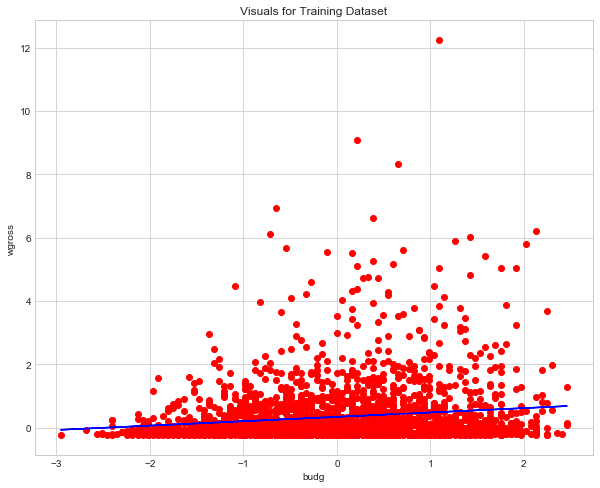

In [48]:
# Visualising the training set results
plt.scatter(X_train, y_train, color = 'red')
plt.plot(X_train, lin.predict(X_train), color = 'blue')
plt.title ("Visuals for Training Dataset")
plt.xlabel("budg")
plt.ylabel("wgross")
plt.show()

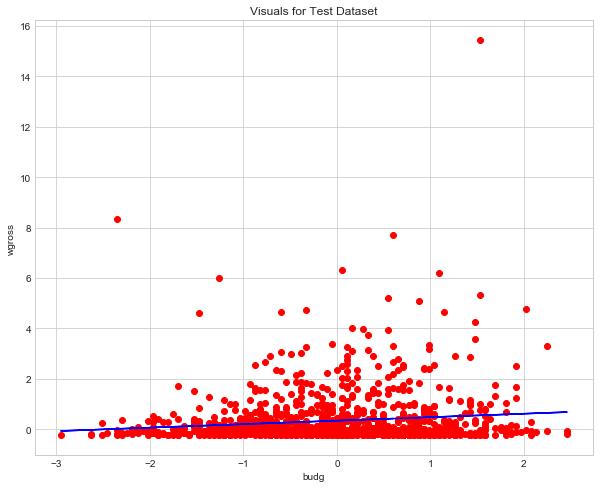

In [49]:
plt.scatter(X_test, y_test , color = 'red')
plt.plot(X_train, lin.predict(X_train), color = 'blue')
plt.title ("Visuals for Test Dataset")
plt.xlabel("budg")
plt.ylabel("wgross")
plt.show()

In [50]:
from sklearn import neighbors
n_neighbors=5
knn=neighbors.KNeighborsRegressor(n_neighbors,weights='uniform')
knn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform')

In [51]:
knn_score_train = knn.score(X_test, y_test)
knn_score_test = knn.score(X_train, y_train)

print("Training score: ",knn_score_train)
print("Testing score: ",knn_score_test)

Training score:  -0.11128857298979768
Testing score:  -0.09396828805027546
